In [42]:
import json
import random
from gensim.models import FastText
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import re
import string
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set Random Seeds

In [44]:
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Load Processed Text Samples with Stopwords

Here we load and extract the processed AI-generated and human-generated text samples from JSON files containing texts with stopwords included.

In [45]:
ai_essays_with_stop_words = json.load(open('/home/jovyan/NLP/Data/processed_ai_samples_with_stopwords.json'))
human_essays_with_stop_words = json.load(open('/home/jovyan/NLP/Data/processed_human_samples_with_stopwords.json'))

In [46]:
ai_texts_with_stop_words = [sample["text"] for sample in ai_essays_with_stop_words]
human_texts_with_stop_words = [sample["text"] for sample in human_essays_with_stop_words]

In [47]:
print("Total AI samples:", len(ai_texts_with_stop_words))
print("Total human samples:", len(human_texts_with_stop_words))

Total AI samples: 71644
Total human samples: 54647


## Visualize Word Clouds for Text Samples

Here we visualize word clouds for AI-generated and human-generated text samples after removing HTML tags. Word clouds provide a visual representation of word frequency in the text corpus.

In [48]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

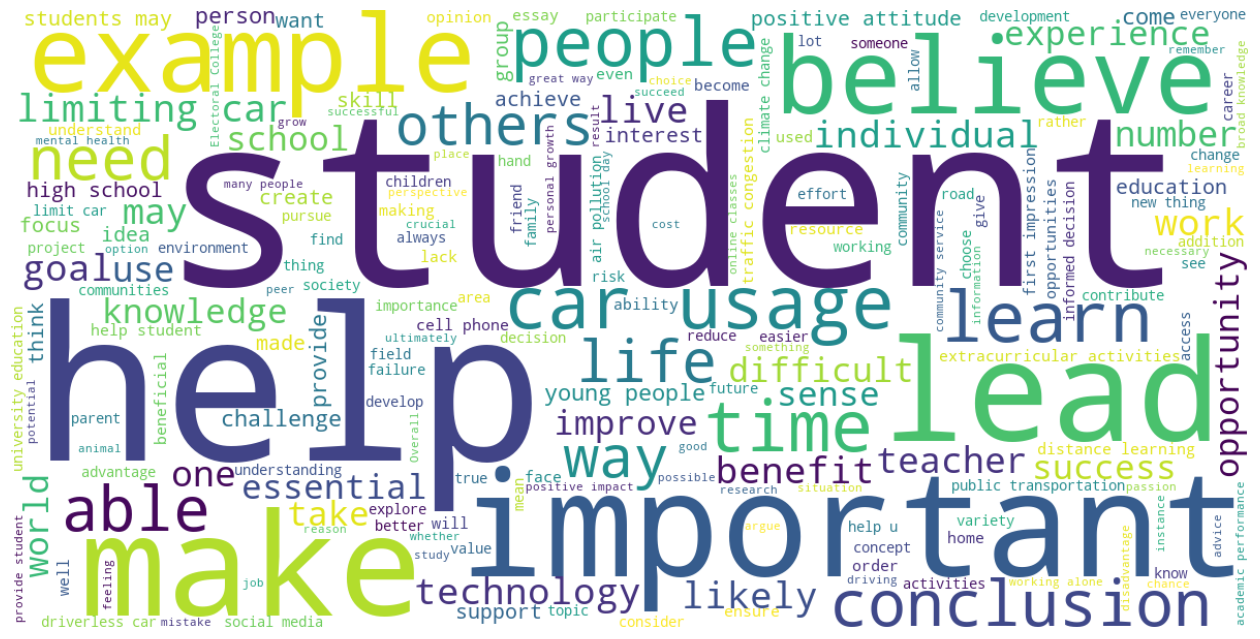

In [49]:
ai_texts_without_tags = [remove_tags(text[0]) for text in ai_texts_with_stop_words]
ai_text_corpus = ' '.join(ai_texts_without_tags)
ai_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(ai_text_corpus)
plt.figure(figsize=(16, 10))
plt.imshow(ai_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

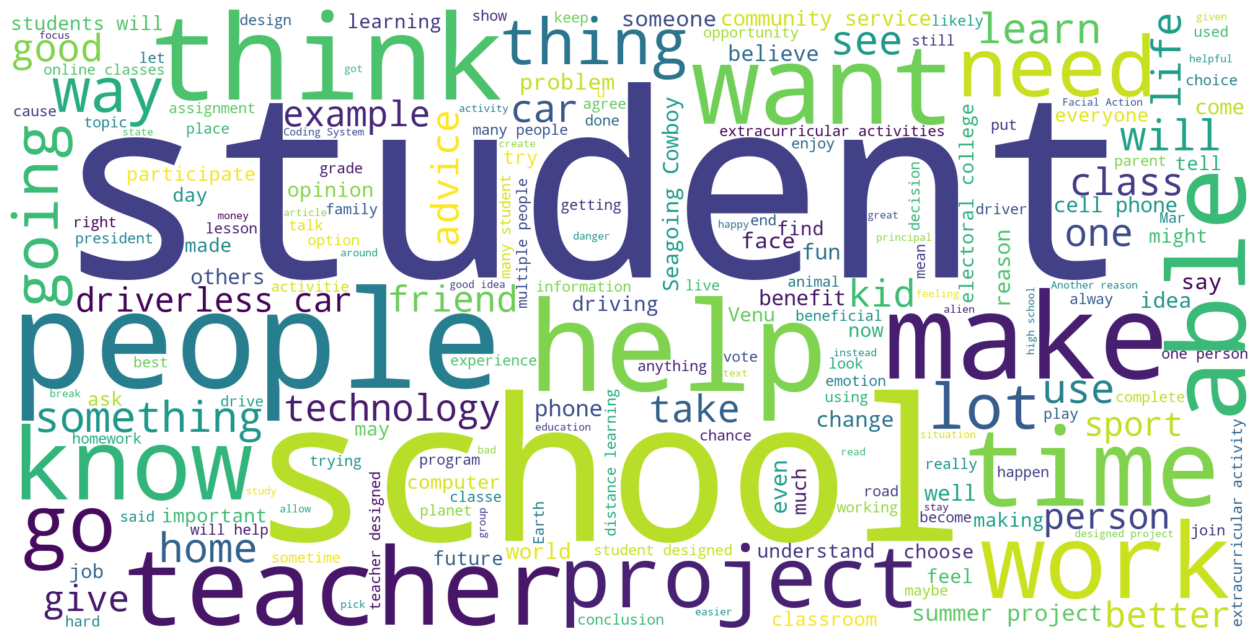

In [50]:
human_texts_without_tags = [remove_tags(text[0]) for text in human_texts_with_stop_words]
human_text_corpus = ' '.join(human_texts_without_tags)
human_wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(human_text_corpus)
plt.figure(figsize=(16, 10))
plt.imshow(human_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [51]:
# plt.figure(figsize=(20, 16))

# plt.subplot(1, 2, 1)  
# plt.imshow(ai_wordcloud, interpolation='bilinear')
# plt.axis('off')
# # plt.title('AI Corpus Word Cloud')

# # Adding caption at the bottom
# plt.text(0.5, -0.1, 'AI Corpus Word Cloud', ha='center', va='center', transform=plt.gca().transAxes, fontsize=24, weight='bold')

# plt.subplot(1, 2, 2)  
# plt.imshow(human_wordcloud, interpolation='bilinear')
# plt.axis('off')
# # plt.title('Human Corpus Word Cloud')

# # Adding caption at the bottom
# plt.text(0.5, -0.1, 'Human Corpus Word Cloud', ha='center', va='center', transform=plt.gca().transAxes, fontsize=24, weight='bold')

# # Save and show the plot
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.05) 
# plt.savefig("/home/jovyan/NLP/Plots/with_stopwords_wordcloud.pdf", format='pdf', bbox_inches='tight')
# plt.show()

## Preprocess Texts and Analyze N-grams

Here we preprocess AI-generated and human-generated text samples by removing HTML tags, converting to lowercase, and removing punctuation. We then extract and analyze n-grams (bigrams, trigrams, and fourgrams) from the tokenized corpus to identify frequently occurring sequences of words.

In [52]:
def preprocess_texts(texts):
    tokenized_texts = []
    for text in texts:
        cleaned_text = remove_tags(text[0]).lower()
        cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
        tokenized_texts.append(word_tokenize(cleaned_text))
    return tokenized_texts

In [53]:
def get_top_ngrams(texts, n, top_k):
    ngrams_list = []
    for text in texts:
        ngrams_list.extend(list(ngrams(text, n)))
    ngrams_counts = Counter(ngrams_list)
    return ngrams_counts.most_common(top_k)

In [54]:
ai_tokenized_texts = preprocess_texts(ai_texts_with_stop_words)
human_tokenized_texts = preprocess_texts(human_texts_with_stop_words)
tokenized_corpus = ai_tokenized_texts + human_tokenized_texts

In [55]:
top_bigrams = get_top_ngrams(tokenized_corpus, n=2, top_k=10)
top_trigrams = get_top_ngrams(tokenized_corpus, n=3, top_k=10)
top_fourgrams = get_top_ngrams(tokenized_corpus, n=4, top_k=10)

In [56]:
def plot_ngrams(top_ngrams, title):
    ngrams, counts = zip(*top_ngrams)
    ngrams = [' '.join(ngram) for ngram in ngrams]
    plt.barh(ngrams, counts, color='skyblue')
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

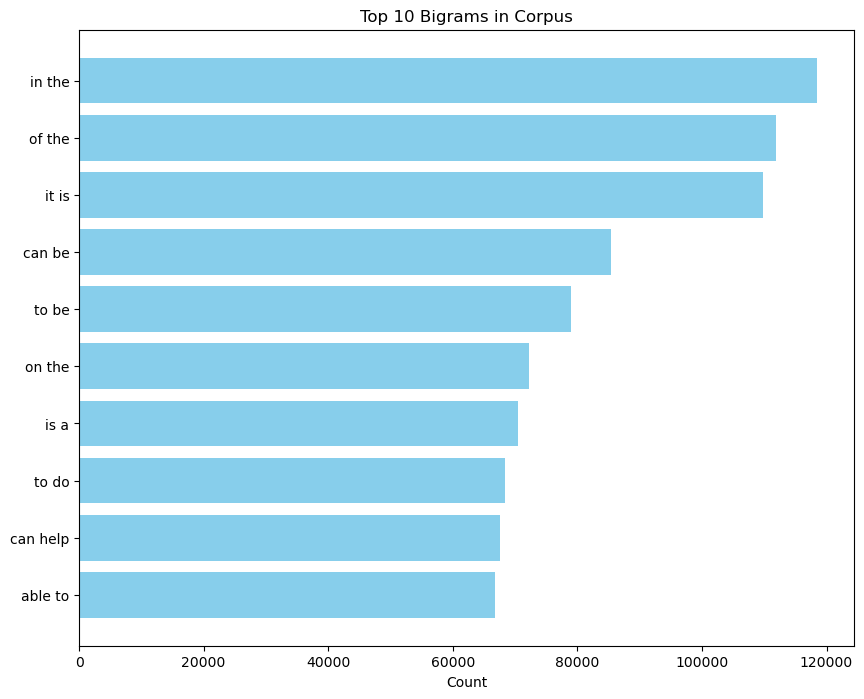

In [57]:
plt.figure(figsize=(10, 8))
plot_ngrams(top_bigrams, 'Top 10 Bigrams in Corpus')

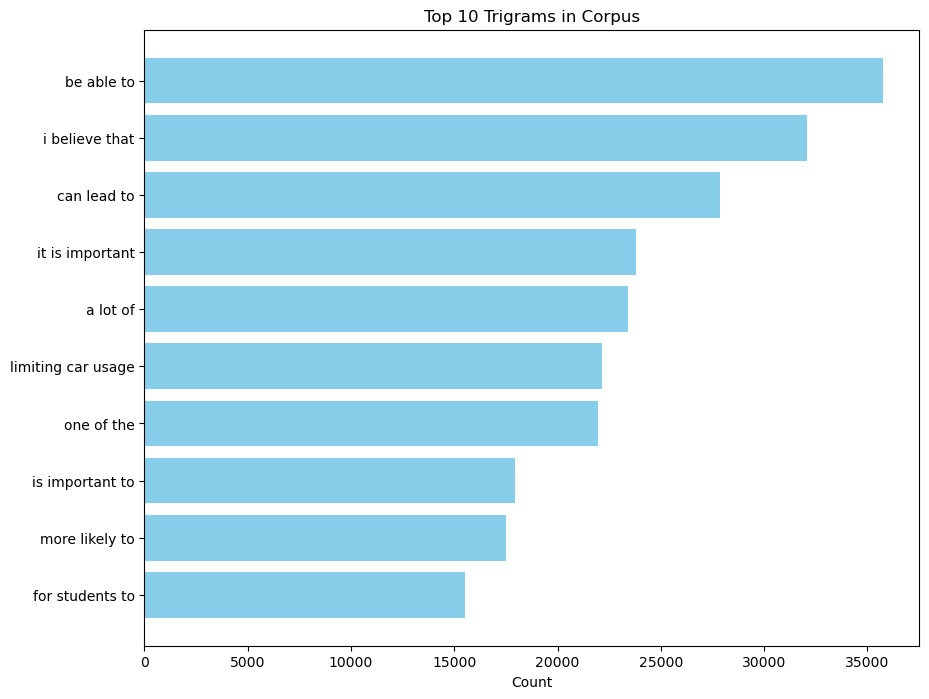

In [58]:
plt.figure(figsize=(10, 8))
plot_ngrams(top_trigrams, 'Top 10 Trigrams in Corpus')

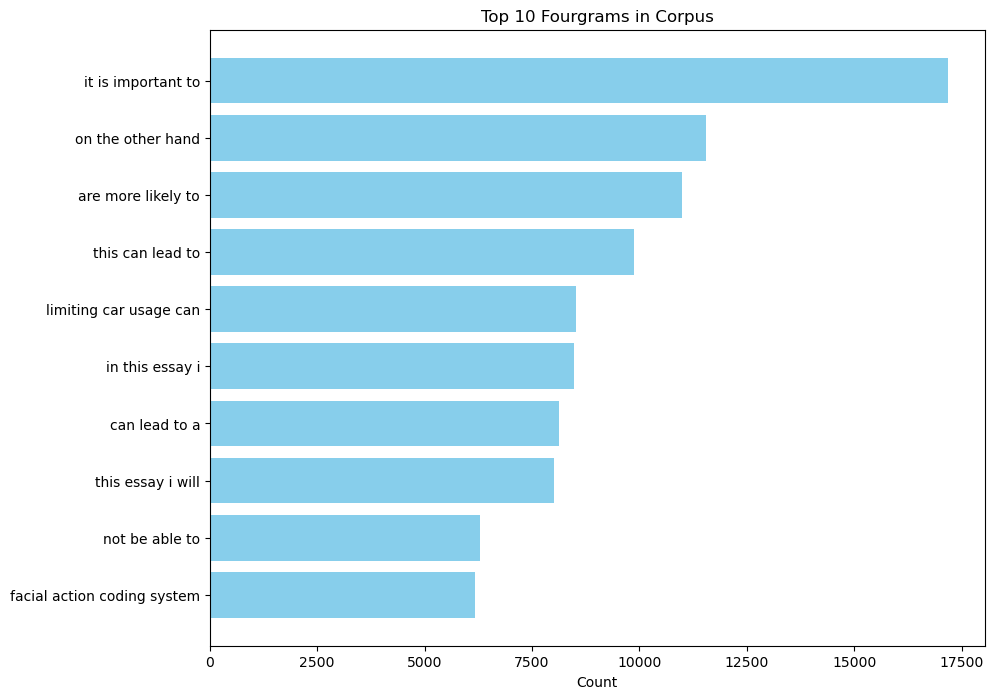

In [59]:
plt.figure(figsize=(10, 8))
plot_ngrams(top_fourgrams, 'Top 10 Fourgrams in Corpus')

## Create FastText Embeddings and Prepare Training and Testing Data

Here we utilize FastText embeddings to represent AI-generated and human-generated text samples as vectors. We preprocess the texts, build a FastText model on the combined corpus, and then generate word vectors for each tokenized text. These vectors are organized with their respective labels (1.0 for AI-generated and 0.0 for human-generated). We split the data into training and testing sets, preparing them for further classification

In [60]:
def fast_text_model(corpus, vector_size):
    model = FastText(vector_size=vector_size)
    model.build_vocab(corpus)
    return model

In [61]:
def get_word_vector(model, word):
    return torch.tensor(model.wv[word])

In [62]:
def get_text_vectors_with_labels(model, texts, label):
    text_with_vectors = []
    for text in texts:
        word_vectors = []
        for word in word_tokenize(text):
            word_vector = get_word_vector(model, word)
            word_vectors.append(word_vector)
        word_vectors = torch.stack(word_vectors)
        text_with_vectors.append({"text": text, "vector": word_vectors, "label": label})
    return text_with_vectors

In [63]:
corpus = ai_texts_with_stop_words + human_texts_with_stop_words
text_model = fast_text_model(corpus, 300)

In [64]:
n = 1000
train_ai_text_vectors = []
for text in ai_texts_with_stop_words[:n]:
    train_ai_text_vectors.append(get_text_vectors_with_labels(text_model, text, 1.0))

train_human_text_vectors = []
for text in human_texts_with_stop_words[:n]:
    train_human_text_vectors.append(get_text_vectors_with_labels(text_model, text, 0.0))

In [65]:
training_labels = []
training_vectors = []
for sample in train_ai_text_vectors + train_human_text_vectors:
    training_labels.append(sample[0]["label"])
    training_vectors.append(sample[0]["vector"])
training_data = list(zip(training_vectors, training_labels))
print("Number of samples in training data", len(training_data))

Number of samples in training data 2000


In [66]:
m = 250
test_ai_text_vectors = []
for text in ai_texts_with_stop_words[n:n+m]:
    test_ai_text_vectors.extend(get_text_vectors_with_labels(text_model, text, 1.0))

test_human_text_vectors = []
for text in human_texts_with_stop_words[n:n+m]:
    test_human_text_vectors.extend(get_text_vectors_with_labels(text_model, text, 0.0))

In [67]:
testing_vectors = [sample["vector"] for sample in test_ai_text_vectors] + [sample["vector"] for sample in test_human_text_vectors]
testing_labels = [sample["label"] for sample in test_ai_text_vectors] + [sample["label"] for sample in test_human_text_vectors]
testing_data = list(zip(testing_vectors, testing_labels))
print("Number of samples in testing data", len(testing_data))

Number of samples in testing data 500


## LSTM Model Training with Triplet Loss

The model is designed to minimize the triplet loss function, which encourages the model to learn embeddings such that the distance between an anchor and a positive example is smaller than the distance between the anchor and a negative example by at least a margin. This process involves:
1.  Triplet creation from training data ensures each anchor has a positive and a negative example.
2.  An LSTM model is defined to encode sequences into embeddings, which are then passed through a linear layer to reduce dimensionality.
3.  The TripletLoss function computes the loss based on the distances between anchor, positive, and negative embeddings.
4.  The training loop iterates through epochs, batches, and triplets, calculating losses and updating model parameters using backpropagation.(The commented-out code defines and trains an LSTM-based model to embed text sequences into a lower-dimensional )

In [68]:
def create_padded_triplets(data):
    sequences = [item[0] for item in data]
    labels = [item[1] for item in data]
    
    triplets = []
    for i, (anchor_seq, anchor_label) in enumerate(data):
        positive_seq = None
        negative_seq = None

        for j, (seq, label) in enumerate(data):
            if label == anchor_label and i != j:
                positive_seq = seq
            if label != anchor_label:
                negative_seq = seq
                break

        if positive_seq is not None and negative_seq is not None:
            triplets.append((anchor_seq, positive_seq, negative_seq))
    
    return triplets

In [69]:
def pad_sequences(sequences):
    lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, lengths

In [70]:
class LSTMEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, n_layers=2):
        super(LSTMEmbedder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, embedding_dim)
        
    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        last_hidden_state = hn[-1]
        embeddings = self.fc(last_hidden_state)
        
        return embeddings

In [71]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist = torch.nn.functional.pairwise_distance(anchor, positive)
        neg_dist = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.mean(torch.relu(pos_dist - neg_dist + self.margin))
        return loss

triplet_loss = TripletLoss(margin=1.0)

In [72]:
model_with_stopwords = LSTMEmbedder(300, 10, 100, n_layers=2).to(device)

In [73]:
# optimizer = optim.Adam(model_with_stopwords.parameters(), lr=0.0001)
# num_epochs=20
# batch_size=64
# losses = []
# for epoch in range(num_epochs):
#     total_loss = 0
#     random.shuffle(training_data) 
#     triplets = create_padded_triplets(training_data)
#     num_triplets = len(triplets)
#     model_with_stopwords.train()
#     for i in range(0, num_triplets, batch_size):
#         batch_triplets = triplets[i:i+batch_size]
#         padded_triplets = [(pad_sequences([anchor, positive, negative])) for anchor, positive, negative in batch_triplets]
        
#         batch_loss = 0
#         for (padded_triplet, lengths) in padded_triplets:
#             anchor, positive, negative = [x.to(device) for x in padded_triplet]
#             anchor_len, positive_len, negative_len = lengths
            
            
#             anchor_embed = model_with_stopwords(anchor.unsqueeze(0), [anchor_len])
#             positive_embed = model_with_stopwords(positive.unsqueeze(0), [positive_len])
#             negative_embed = model_with_stopwords(negative.unsqueeze(0), [negative_len])
            
#             loss = triplet_loss(anchor_embed, positive_embed, negative_embed)
#             batch_loss += loss.item()
            
            
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
        
#         total_loss += batch_loss / len(padded_triplets)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / (num_triplets // batch_size)}')
#     epoch_loss = total_loss / (num_triplets // batch_size)
#     losses.append(epoch_loss)

In [74]:
# torch.save(model_with_stopwords.state_dict(), "/home/jovyan/NLP/TrainedModels/with_stopwords_model.pth")

In [75]:
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs+1), losses, color='blue')
# plt.title("Training Curve")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.ylim(0, 1)
# plt.grid(True)
# plt.show()

### Loading the saved model

In [76]:
model_with_stopwords.load_state_dict(torch.load("/home/jovyan/NLP/TrainedModels/with_stopwords_model.pth"))
model_with_stopwords.eval()

LSTMEmbedder(
  (lstm): LSTM(300, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=100, bias=True)
)

## Evaluating LSTM Embeddings with SVM Classifier

The provided code evaluates the LSTM model's embeddings using a Support Vector Machine (SVM) classifier for classification tasks on text data. Here's a summary of the process:

1. Embedding Extraction: The get_embeddings function retrieves embeddings from the LSTM model for both training and testing datasets.

2. SVM Classifier: An SVM model (SVC) with a linear kernel is trained using the LSTM embeddings from the training set (train_lstm_embeddings) and their corresponding labels (train_labels).

3. Evaluation: The SVM model predicts labels for the test set embeddings to evaluate model performance.

In [77]:
def get_embeddings(data, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for seq, label in data:
            padded_seq, lengths = pad_sequences([seq])
            padded_seq = padded_seq.to(device)
            embedding = model(padded_seq, lengths)
            embeddings.append(embedding.squeeze(0).cpu().numpy())
            labels.append(label)
    return embeddings, labels
train_lstm_embeddings, train_labels = get_embeddings(training_data, model_with_stopwords)
test_lstm_embeddings, test_labels = get_embeddings(testing_data, model_with_stopwords)

In [78]:
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_lstm_embeddings, train_labels)

SVC(kernel='linear', probability=True)

In [79]:
test_predictions = svm_model.predict(test_lstm_embeddings)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Test accuracy: 83.80%


In [80]:
class_report = classification_report(test_labels, test_predictions)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       250
         1.0       0.84      0.83      0.84       250

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



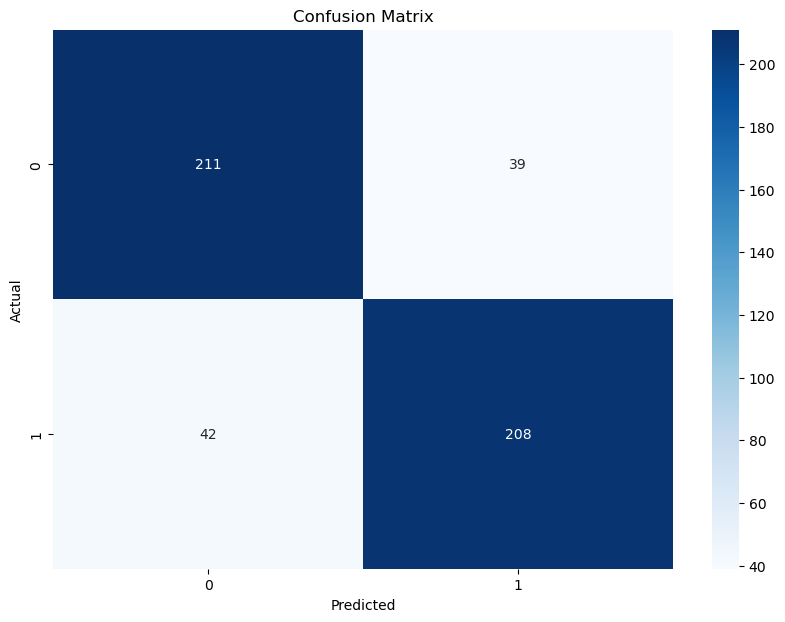

In [81]:
conf_mat = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [82]:
# labels = ['Human', 'AI']

# # Plotting the confusion matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"fontsize": 32})

# # Adjust labels font size and weight
# plt.xlabel('Predicted', fontsize=32, fontweight='bold')
# plt.ylabel('Actual', fontsize=32, fontweight='bold')

# # Adjust tick labels font size and weight
# plt.xticks(fontsize=24, fontweight='bold')
# plt.yticks(fontsize=24, fontweight='bold')

# # Save and display the plot
# plt.savefig("/home/jovyan/NLP/Plots/confusion_matrix_with_stopwords.pdf", format='pdf', bbox_inches='tight')
# plt.show()